In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv


# Neural Network-Based Flow Field Compression — Online Training & Evaluation
Streaming in-situ training with temporal windows.
- **Base Model**: 4 → 64 → 64 → 32 → 4 (6,692 parameters)
- **Large Model**: 4 → 128 → 128 → 64 → 4 (25,668 parameters)

In [2]:
"""Unified Utilities for Neural Network-Based Flow Field Compression"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pyarrow.csv as pv
from torcheval.metrics import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import time
import os
import json


class FlowFieldDataset(Dataset):
    """Spatio-temporal flow field dataset with min-max normalization to [0, 1]."""

    def __init__(self, filepath):
        print(f"[Data] Loading dataset from {filepath}")
        read_options = pv.ReadOptions(
            column_names=['x', 'y', 'z', 't', 'Vx', 'Vy', 'Pressure', 'TKE']
        )
        table = pv.read_csv(filepath, read_options=read_options)
        data = table.to_pandas().values
        self.inputs = data[:, :4].astype(np.float32)
        self.targets = data[:, 4:].astype(np.float32)
        print("[Data] Applying min-max normalization to [0, 1] range")
        self.input_min = self.inputs.min(axis=0)
        self.input_max = self.inputs.max(axis=0)
        self.input_range = self.input_max - self.input_min
        self.input_range[self.input_range == 0] = 1.0
        self.inputs = (self.inputs - self.input_min) / self.input_range
        self.target_min = self.targets.min(axis=0)
        self.target_max = self.targets.max(axis=0)
        self.target_range = self.target_max - self.target_min
        self.target_range[self.target_range == 0] = 1.0
        self.targets = (self.targets - self.target_min) / self.target_range
        print(f"[Data] Loaded {len(self):,} samples | Input: {self.inputs.shape} | Target: {self.targets.shape}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(self.targets[idx])

    def denormalize_input(self, normalized):
        if isinstance(normalized, torch.Tensor):
            normalized = normalized.cpu().numpy()
        return normalized * self.input_range + self.input_min

    def denormalize_target(self, normalized):
        if isinstance(normalized, torch.Tensor):
            normalized = normalized.cpu().numpy()
        return normalized * self.target_range + self.target_min


class BaseCompressor(nn.Module):
    """Base compression network: 4 -> 64 -> 64 -> 32 -> 4"""

    def __init__(self):
        super(BaseCompressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.model(x)


class LargeCompressor(nn.Module):
    """Large compression network: 4 -> 128 -> 128 -> 64 -> 4"""

    def __init__(self):
        super(LargeCompressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.model(x)


def compute_psnr_ssim(predictions, targets, device):
    """Compute PSNR and SSIM for regression data using per-point comparison (kernel_size=1)."""
    predictions = predictions.to(device)
    targets = targets.to(device)

    psnr_metric = PeakSignalNoiseRatio().to(device)
    psnr_metric.update(predictions, targets)
    psnr = psnr_metric.compute().item()

    pred_ssim = predictions.view(-1, 1, 1, predictions.shape[1])
    target_ssim = targets.view(-1, 1, 1, targets.shape[1])
    pred_ssim = pred_ssim.permute(1, 2, 0, 3)
    target_ssim = target_ssim.permute(1, 2, 0, 3)

    ssim_metric = StructuralSimilarityIndexMeasure(
        gaussian_kernel=False, kernel_size=1
    ).to(device)
    ssim_metric.update(pred_ssim, target_ssim)
    ssim = ssim_metric.compute().item()

    return psnr, ssim


def compute_relative_error(predictions, targets):
    """Compute relative L2 norm error as a percentage."""
    target_norm = torch.norm(targets)
    error = torch.norm(predictions - targets)
    return (error / target_norm * 100).item()


def train_online(model, dataset, device, epochs_per_window, model_name, output_dir, num_windows=20):
    """Train a compression model using online streaming with temporal windows."""
    os.makedirs(output_dir, exist_ok=True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    all_metrics = {
        'window': [],
        'loss': [],
        'psnr': [],
        'ssim': [],
        'relative_error': [],
        'time_per_window': []
    }

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n[Train] Model: {model_name}")
    print(f"[Train] Samples: {len(dataset):,} | Windows: {num_windows} | Epochs/Window: {epochs_per_window}")
    print(f"[Train] Device: {device} | Parameters: {total_params:,} | Size: {total_params * 4 / 1024:.2f} KB")

    coords_denorm = dataset.denormalize_input(dataset.inputs)
    unique_times = np.unique(coords_denorm[:, 3])
    times_per_window = len(unique_times) // num_windows
    print(f"[Train] Unique timesteps: {len(unique_times)} | Timesteps/Window: {times_per_window}\n")

    for window_idx in range(num_windows):
        window_start_time = time.time()

        start_idx = window_idx * times_per_window
        end_idx = start_idx + times_per_window if window_idx < num_windows - 1 else len(unique_times)
        window_times = unique_times[start_idx:end_idx]

        time_mask = np.isin(coords_denorm[:, 3], window_times)
        window_inputs = torch.from_numpy(dataset.inputs[time_mask]).to(device)
        window_targets = torch.from_numpy(dataset.targets[time_mask]).to(device)

        print(f"  Window {window_idx+1:>2}/{num_windows}: {len(window_inputs):,} samples, "
              f"t=[{window_times[0]:.4f}, {window_times[-1]:.4f}]")

        for epoch in range(epochs_per_window):
            model.train()
            optimizer.zero_grad()
            outputs = model(window_inputs)
            loss = criterion(outputs, window_targets)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            predictions = model(window_inputs)

        loss_val = criterion(predictions, window_targets).item()
        psnr, ssim = compute_psnr_ssim(predictions, window_targets, device)
        rel_error = compute_relative_error(predictions, window_targets)

        window_time = time.time() - window_start_time

        all_metrics['window'].append(window_idx + 1)
        all_metrics['loss'].append(loss_val)
        all_metrics['psnr'].append(psnr)
        all_metrics['ssim'].append(ssim)
        all_metrics['relative_error'].append(rel_error)
        all_metrics['time_per_window'].append(window_time)

        print(f"           Loss={loss_val:.6f}, PSNR={psnr:.2f} dB, SSIM={ssim:.4f}, "
              f"Rel. Error={rel_error:.2f}%, Time={window_time:.2f}s")

        window_dir = os.path.join(output_dir, f'window_{window_idx+1:02d}')
        os.makedirs(window_dir, exist_ok=True)
        torch.save(model.state_dict(),
                   os.path.join(window_dir, f'{model_name}_window_{window_idx+1:02d}.pth'))

    final_model_path = os.path.join(output_dir, f'{model_name}_online_final.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"\n[Train] Final model saved: {final_model_path}")

    norm_params = {
        'input_min': dataset.input_min.tolist(),
        'input_max': dataset.input_max.tolist(),
        'input_range': dataset.input_range.tolist(),
        'target_min': dataset.target_min.tolist(),
        'target_max': dataset.target_max.tolist(),
        'target_range': dataset.target_range.tolist()
    }
    norm_path = os.path.join(output_dir, f'{model_name}_normalization.json')
    with open(norm_path, 'w') as f:
        json.dump(norm_params, f, indent=2)
    print(f"[Train] Normalization parameters saved: {norm_path}")

    summary = {
        'model_name': model_name,
        'total_windows': num_windows,
        'epochs_per_window': epochs_per_window,
        'total_epochs': num_windows * epochs_per_window,
        'final_loss': all_metrics['loss'][-1],
        'final_psnr': all_metrics['psnr'][-1],
        'final_ssim': all_metrics['ssim'][-1],
        'final_relative_error': all_metrics['relative_error'][-1],
        'total_training_time': sum(all_metrics['time_per_window']),
        'avg_time_per_window': np.mean(all_metrics['time_per_window'])
    }
    summary_path = os.path.join(output_dir, 'online_training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n[Train] Online training completed for {model_name}")
    print(f"  Total Windows:        {num_windows}")
    print(f"  Total Epochs:         {num_windows * epochs_per_window}")
    print(f"  Final Loss:           {all_metrics['loss'][-1]:.6f}")
    print(f"  Final PSNR:           {all_metrics['psnr'][-1]:.2f} dB")
    print(f"  Final SSIM:           {all_metrics['ssim'][-1]:.4f}")
    print(f"  Final Relative Error: {all_metrics['relative_error'][-1]:.2f}%")
    print(f"  Total Time:           {sum(all_metrics['time_per_window']):.2f}s\n")

    return all_metrics


def export_metrics_csv(metrics, output_path):
    """Export training metrics history to CSV."""
    df = pd.DataFrame(metrics)
    df.to_csv(output_path, index=False)
    print(f"[Export] Metrics saved: {output_path}")

In [3]:
DATA_FILE = "/kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv"
EPOCHS_PER_WINDOW = 100
NUM_WINDOWS = 100
TIMESTEP = 0.0396

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Config] Device: {device}")

dataset = FlowFieldDataset(DATA_FILE)

[Config] Device: cuda
[Data] Loading dataset from /kaggle/input/datasets/maheshsadupalli/ml-test-loader-original-data-csv/ML_test_loader_original_data.csv
[Data] Applying min-max normalization to [0, 1] range
[Data] Loaded 7,919,100 samples | Input: (7919100, 4) | Target: (7919100, 4)


---
## 1. Base Model (64-64-32) — Online Training

In [4]:
BASE_OUTPUT_DIR = "/kaggle/working/results/base_model_online"

base_model = BaseCompressor().to(device)

base_metrics = train_online(
    model=base_model,
    dataset=dataset,
    device=device,
    epochs_per_window=EPOCHS_PER_WINDOW,
    model_name='base_model',
    output_dir=BASE_OUTPUT_DIR,
    num_windows=NUM_WINDOWS
)

export_metrics_csv(base_metrics, f"{BASE_OUTPUT_DIR}/base_model_online_metrics.csv")


[Train] Model: base_model
[Train] Samples: 7,919,100 | Windows: 100 | Epochs/Window: 100
[Train] Device: cuda | Parameters: 6,692 | Size: 26.14 KB
[Train] Unique timesteps: 300 | Timesteps/Window: 3

  Window  1/100: 79,191 samples, t=[0.0000, 0.0102]
           Loss=0.008292, PSNR=20.81 dB, SSIM=0.8675, Rel. Error=15.29%, Time=2.41s
  Window  2/100: 79,191 samples, t=[0.0103, 0.0105]
           Loss=0.008170, PSNR=20.88 dB, SSIM=0.8901, Rel. Error=15.16%, Time=0.37s
  Window  3/100: 79,191 samples, t=[0.0106, 0.0108]
           Loss=0.008096, PSNR=20.92 dB, SSIM=0.8891, Rel. Error=15.11%, Time=0.37s
  Window  4/100: 79,191 samples, t=[0.0109, 0.0111]
           Loss=0.007754, PSNR=21.10 dB, SSIM=0.8878, Rel. Error=14.85%, Time=0.37s
  Window  5/100: 79,191 samples, t=[0.0112, 0.0114]
           Loss=0.007279, PSNR=21.38 dB, SSIM=0.8850, Rel. Error=14.44%, Time=0.37s
  Window  6/100: 79,191 samples, t=[0.0115, 0.0117]
           Loss=0.006669, PSNR=21.76 dB, SSIM=0.8819, Rel. Error=13

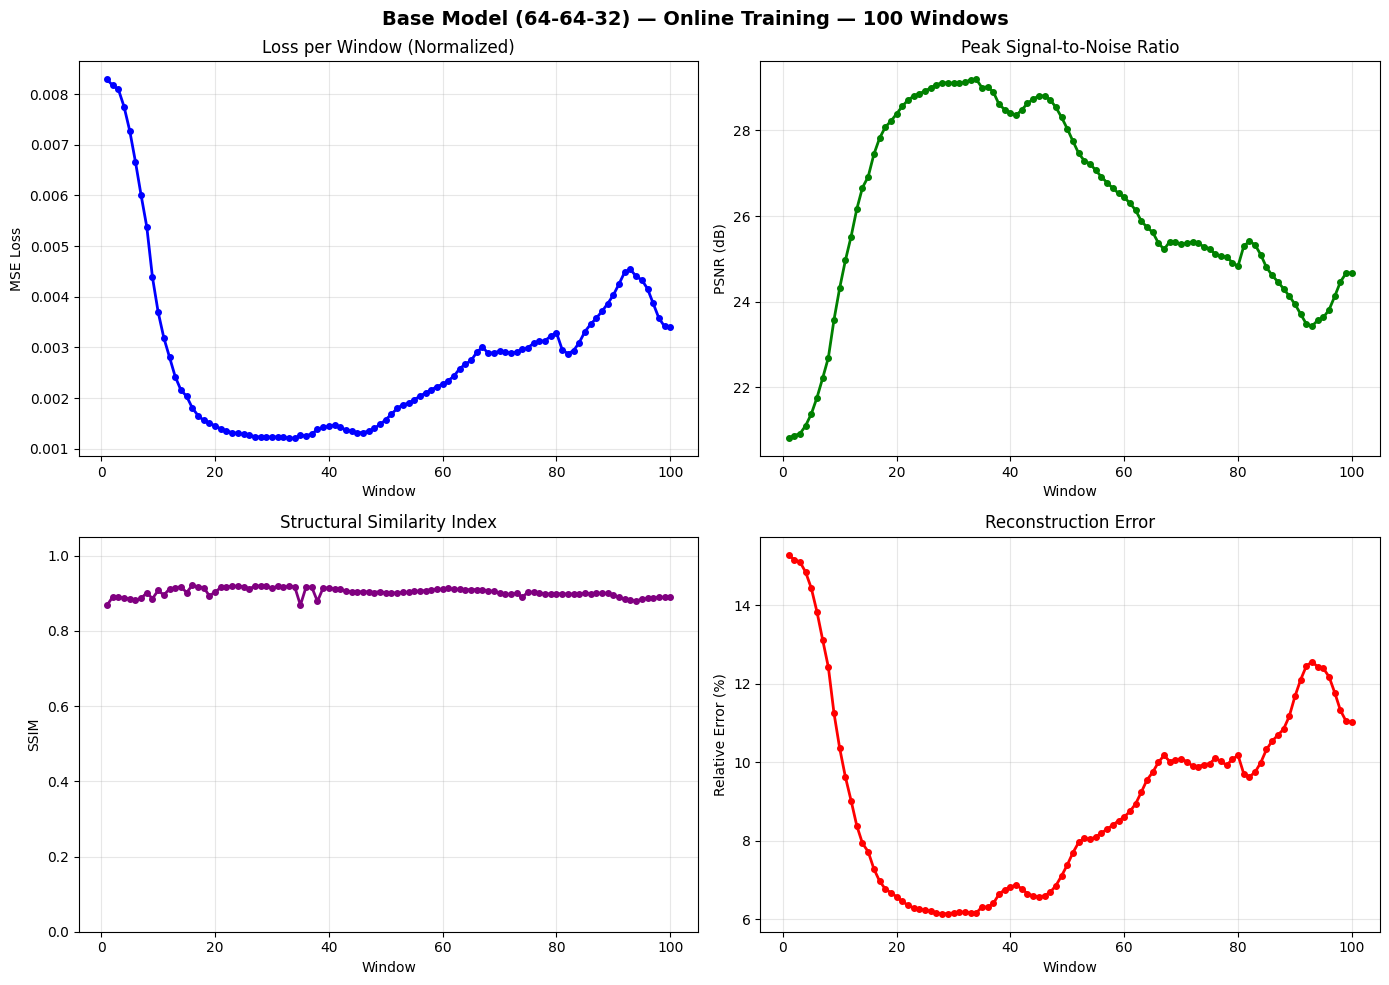

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(base_metrics['window'], base_metrics['loss'], 'b-o', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Window')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Loss per Window (Normalized)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(base_metrics['window'], base_metrics['psnr'], 'g-o', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Window')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Peak Signal-to-Noise Ratio')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(base_metrics['window'], base_metrics['ssim'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].set_xlabel('Window')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_title('Structural Similarity Index')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

axes[1, 1].plot(base_metrics['window'], base_metrics['relative_error'], 'r-o', linewidth=2, markersize=4)
axes[1, 1].set_xlabel('Window')
axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Reconstruction Error')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Base Model (64-64-32) — Online Training — {NUM_WINDOWS} Windows',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{BASE_OUTPUT_DIR}/base_model_online_progress.png", dpi=300, bbox_inches='tight')
plt.show()

## 1.1 Base Model — Evaluation & Visualization

In [6]:
BASE_VIZ_DIR = "/kaggle/working/results/base_model_online_viz"
os.makedirs(BASE_VIZ_DIR, exist_ok=True)

base_model.load_state_dict(torch.load(f"{BASE_OUTPUT_DIR}/base_model_online_final.pth", map_location=device))
base_model.eval()

print(f"[Eval] Base model: {sum(p.numel() for p in base_model.parameters()):,} parameters")

all_inputs = torch.from_numpy(dataset.inputs).to(device)
with torch.no_grad():
    base_predictions = base_model(all_inputs).cpu()

all_targets = torch.from_numpy(dataset.targets)

base_psnr, base_ssim = compute_psnr_ssim(base_predictions, all_targets, device)
print(f"[Eval] PSNR: {base_psnr:.2f} dB | SSIM: {base_ssim:.4f}")

base_pred_denorm = dataset.denormalize_target(base_predictions.numpy())
targets_denorm = dataset.denormalize_target(all_targets.numpy())
coords_denorm = dataset.denormalize_input(dataset.inputs)

timestep_mask = np.abs(coords_denorm[:, 3] - TIMESTEP) < 1e-6
x = coords_denorm[timestep_mask, 0]
y = coords_denorm[timestep_mask, 1]
base_pred_t = base_pred_denorm[timestep_mask]
target_t = targets_denorm[timestep_mask]
base_errors_t = np.abs(target_t - base_pred_t)

print(f"[Eval] Visualizing {len(x):,} points at timestep {TIMESTEP}")

[Eval] Base model: 6,692 parameters
[Eval] PSNR: 4.63 dB | SSIM: 0.6886
[Eval] Visualizing 26,397 points at timestep 0.0396


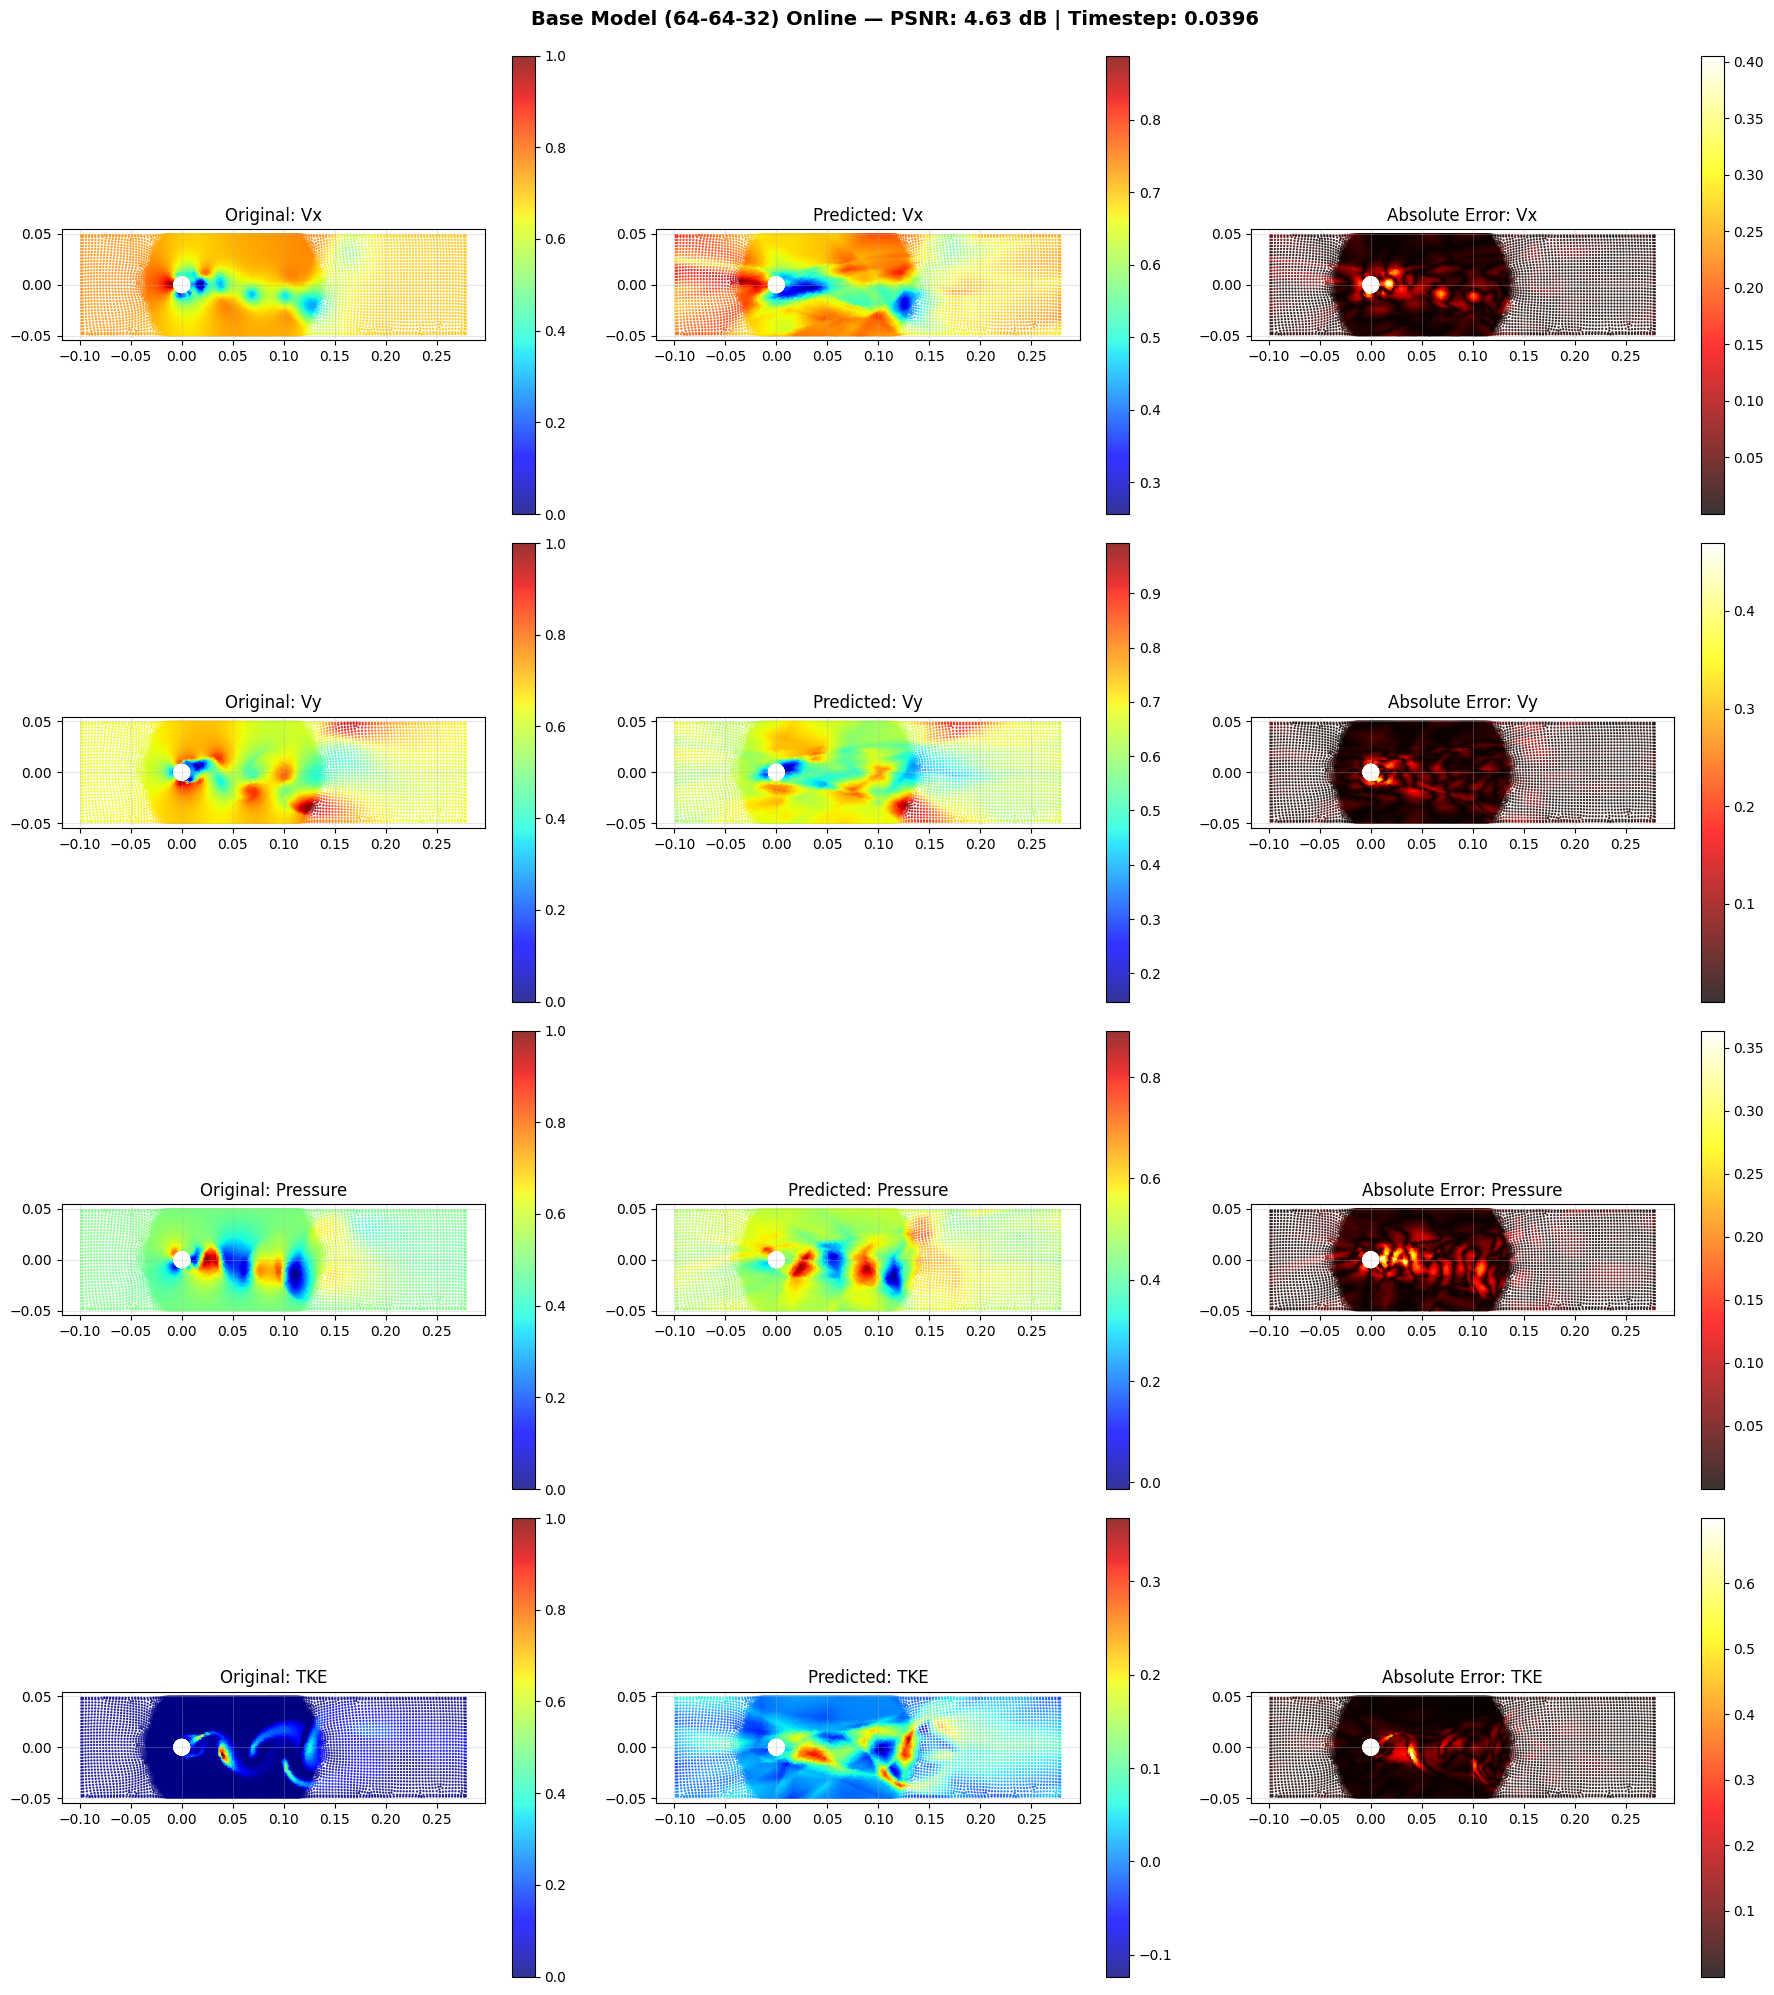

[Eval] Base model evaluation completed


In [7]:
feature_names = ['Vx', 'Vy', 'Pressure', 'TKE']
feature_indices = [0, 1, 2, 3]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (idx, name) in enumerate(zip(feature_indices, feature_names)):
    original = target_t[:, idx]
    predicted = base_pred_t[:, idx]
    error = base_errors_t[:, idx]

    sc1 = axes[row, 0].scatter(x, y, c=original, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 0].set_title(f'Original: {name}')
    axes[row, 0].set_aspect('equal')
    axes[row, 0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[row, 0])

    sc2 = axes[row, 1].scatter(x, y, c=predicted, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 1].set_title(f'Predicted: {name}')
    axes[row, 1].set_aspect('equal')
    axes[row, 1].grid(True, alpha=0.3)
    plt.colorbar(sc2, ax=axes[row, 1])

    sc3 = axes[row, 2].scatter(x, y, c=error, cmap='hot', s=0.5, alpha=0.8)
    axes[row, 2].set_title(f'Absolute Error: {name}')
    axes[row, 2].set_aspect('equal')
    axes[row, 2].grid(True, alpha=0.3)
    plt.colorbar(sc3, ax=axes[row, 2])

plt.suptitle(f'Base Model (64-64-32) Online — PSNR: {base_psnr:.2f} dB | Timestep: {TIMESTEP}',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{BASE_VIZ_DIR}/base_online_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

base_eval_metrics = {
    'model': 'base_model_online_final.pth',
    'architecture': '4-64-64-32-4',
    'training_mode': 'online_streaming',
    'parameters': sum(p.numel() for p in base_model.parameters()),
    'psnr_db': float(base_psnr),
    'ssim': float(base_ssim)
}

with open(f"{BASE_VIZ_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(base_eval_metrics, f, indent=2)

print("[Eval] Base model evaluation completed")

---
## 2. Large Model (128-128-64) — Online Training

In [8]:
LARGE_OUTPUT_DIR = "/kaggle/working/results/large_model_online"

large_model = LargeCompressor().to(device)

large_metrics = train_online(
    model=large_model,
    dataset=dataset,
    device=device,
    epochs_per_window=EPOCHS_PER_WINDOW,
    model_name='large_model',
    output_dir=LARGE_OUTPUT_DIR,
    num_windows=NUM_WINDOWS
)

export_metrics_csv(large_metrics, f"{LARGE_OUTPUT_DIR}/large_model_online_metrics.csv")


[Train] Model: large_model
[Train] Samples: 7,919,100 | Windows: 100 | Epochs/Window: 100
[Train] Device: cuda | Parameters: 25,668 | Size: 100.27 KB
[Train] Unique timesteps: 300 | Timesteps/Window: 3

  Window  1/100: 79,191 samples, t=[0.0000, 0.0102]
           Loss=0.008131, PSNR=20.90 dB, SSIM=0.8884, Rel. Error=15.14%, Time=0.63s
  Window  2/100: 79,191 samples, t=[0.0103, 0.0105]
           Loss=0.007783, PSNR=21.09 dB, SSIM=0.8867, Rel. Error=14.80%, Time=0.61s
  Window  3/100: 79,191 samples, t=[0.0106, 0.0108]
           Loss=0.006722, PSNR=21.73 dB, SSIM=0.8991, Rel. Error=13.76%, Time=0.62s
  Window  4/100: 79,191 samples, t=[0.0109, 0.0111]
           Loss=0.005135, PSNR=22.89 dB, SSIM=0.9156, Rel. Error=12.08%, Time=0.62s
  Window  5/100: 79,191 samples, t=[0.0112, 0.0114]
           Loss=0.003600, PSNR=24.44 dB, SSIM=0.9218, Rel. Error=10.15%, Time=0.61s
  Window  6/100: 79,191 samples, t=[0.0115, 0.0117]
           Loss=0.002547, PSNR=25.94 dB, SSIM=0.9242, Rel. Error

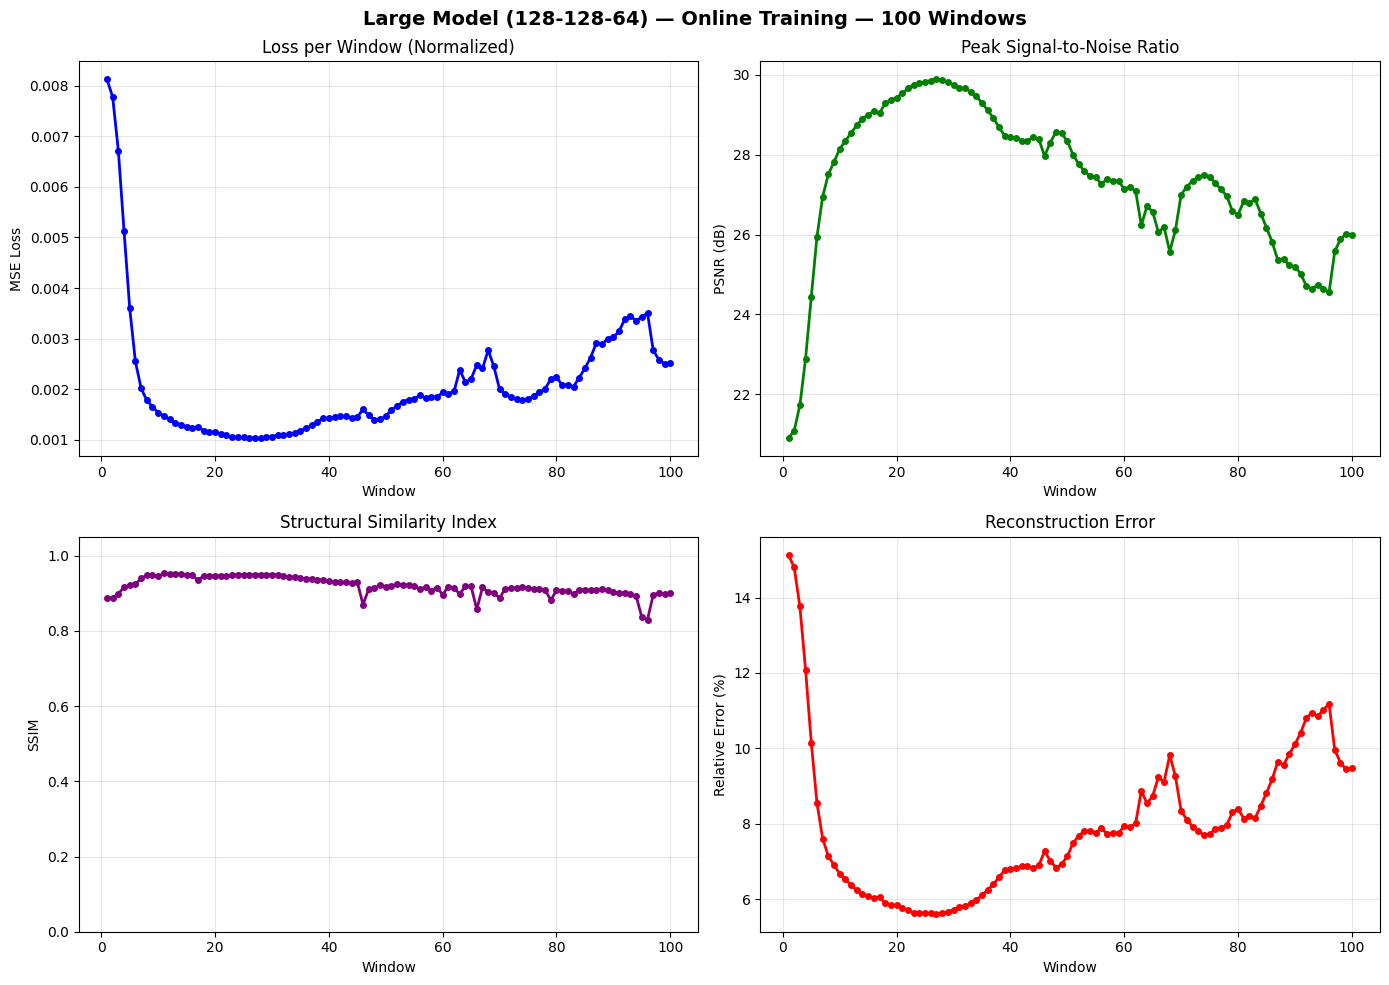

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(large_metrics['window'], large_metrics['loss'], 'b-o', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Window')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Loss per Window (Normalized)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(large_metrics['window'], large_metrics['psnr'], 'g-o', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Window')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Peak Signal-to-Noise Ratio')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(large_metrics['window'], large_metrics['ssim'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].set_xlabel('Window')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_title('Structural Similarity Index')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

axes[1, 1].plot(large_metrics['window'], large_metrics['relative_error'], 'r-o', linewidth=2, markersize=4)
axes[1, 1].set_xlabel('Window')
axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Reconstruction Error')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Large Model (128-128-64) — Online Training — {NUM_WINDOWS} Windows',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{LARGE_OUTPUT_DIR}/large_model_online_progress.png", dpi=300, bbox_inches='tight')
plt.show()

## 2.1 Large Model — Evaluation & Visualization

In [10]:
LARGE_VIZ_DIR = "/kaggle/working/results/large_model_online_viz"
os.makedirs(LARGE_VIZ_DIR, exist_ok=True)

large_model.load_state_dict(torch.load(f"{LARGE_OUTPUT_DIR}/large_model_online_final.pth", map_location=device))
large_model.eval()

print(f"[Eval] Large model: {sum(p.numel() for p in large_model.parameters()):,} parameters")

with torch.no_grad():
    large_predictions = large_model(all_inputs).cpu()

large_psnr, large_ssim = compute_psnr_ssim(large_predictions, all_targets, device)
print(f"[Eval] PSNR: {large_psnr:.2f} dB | SSIM: {large_ssim:.4f}")

large_pred_denorm = dataset.denormalize_target(large_predictions.numpy())

large_pred_t = large_pred_denorm[timestep_mask]
large_errors_t = np.abs(target_t - large_pred_t)

print(f"[Eval] Visualizing {len(x):,} points at timestep {TIMESTEP}")

[Eval] Large model: 25,668 parameters
[Eval] PSNR: 10.26 dB | SSIM: 0.6986
[Eval] Visualizing 26,397 points at timestep 0.0396


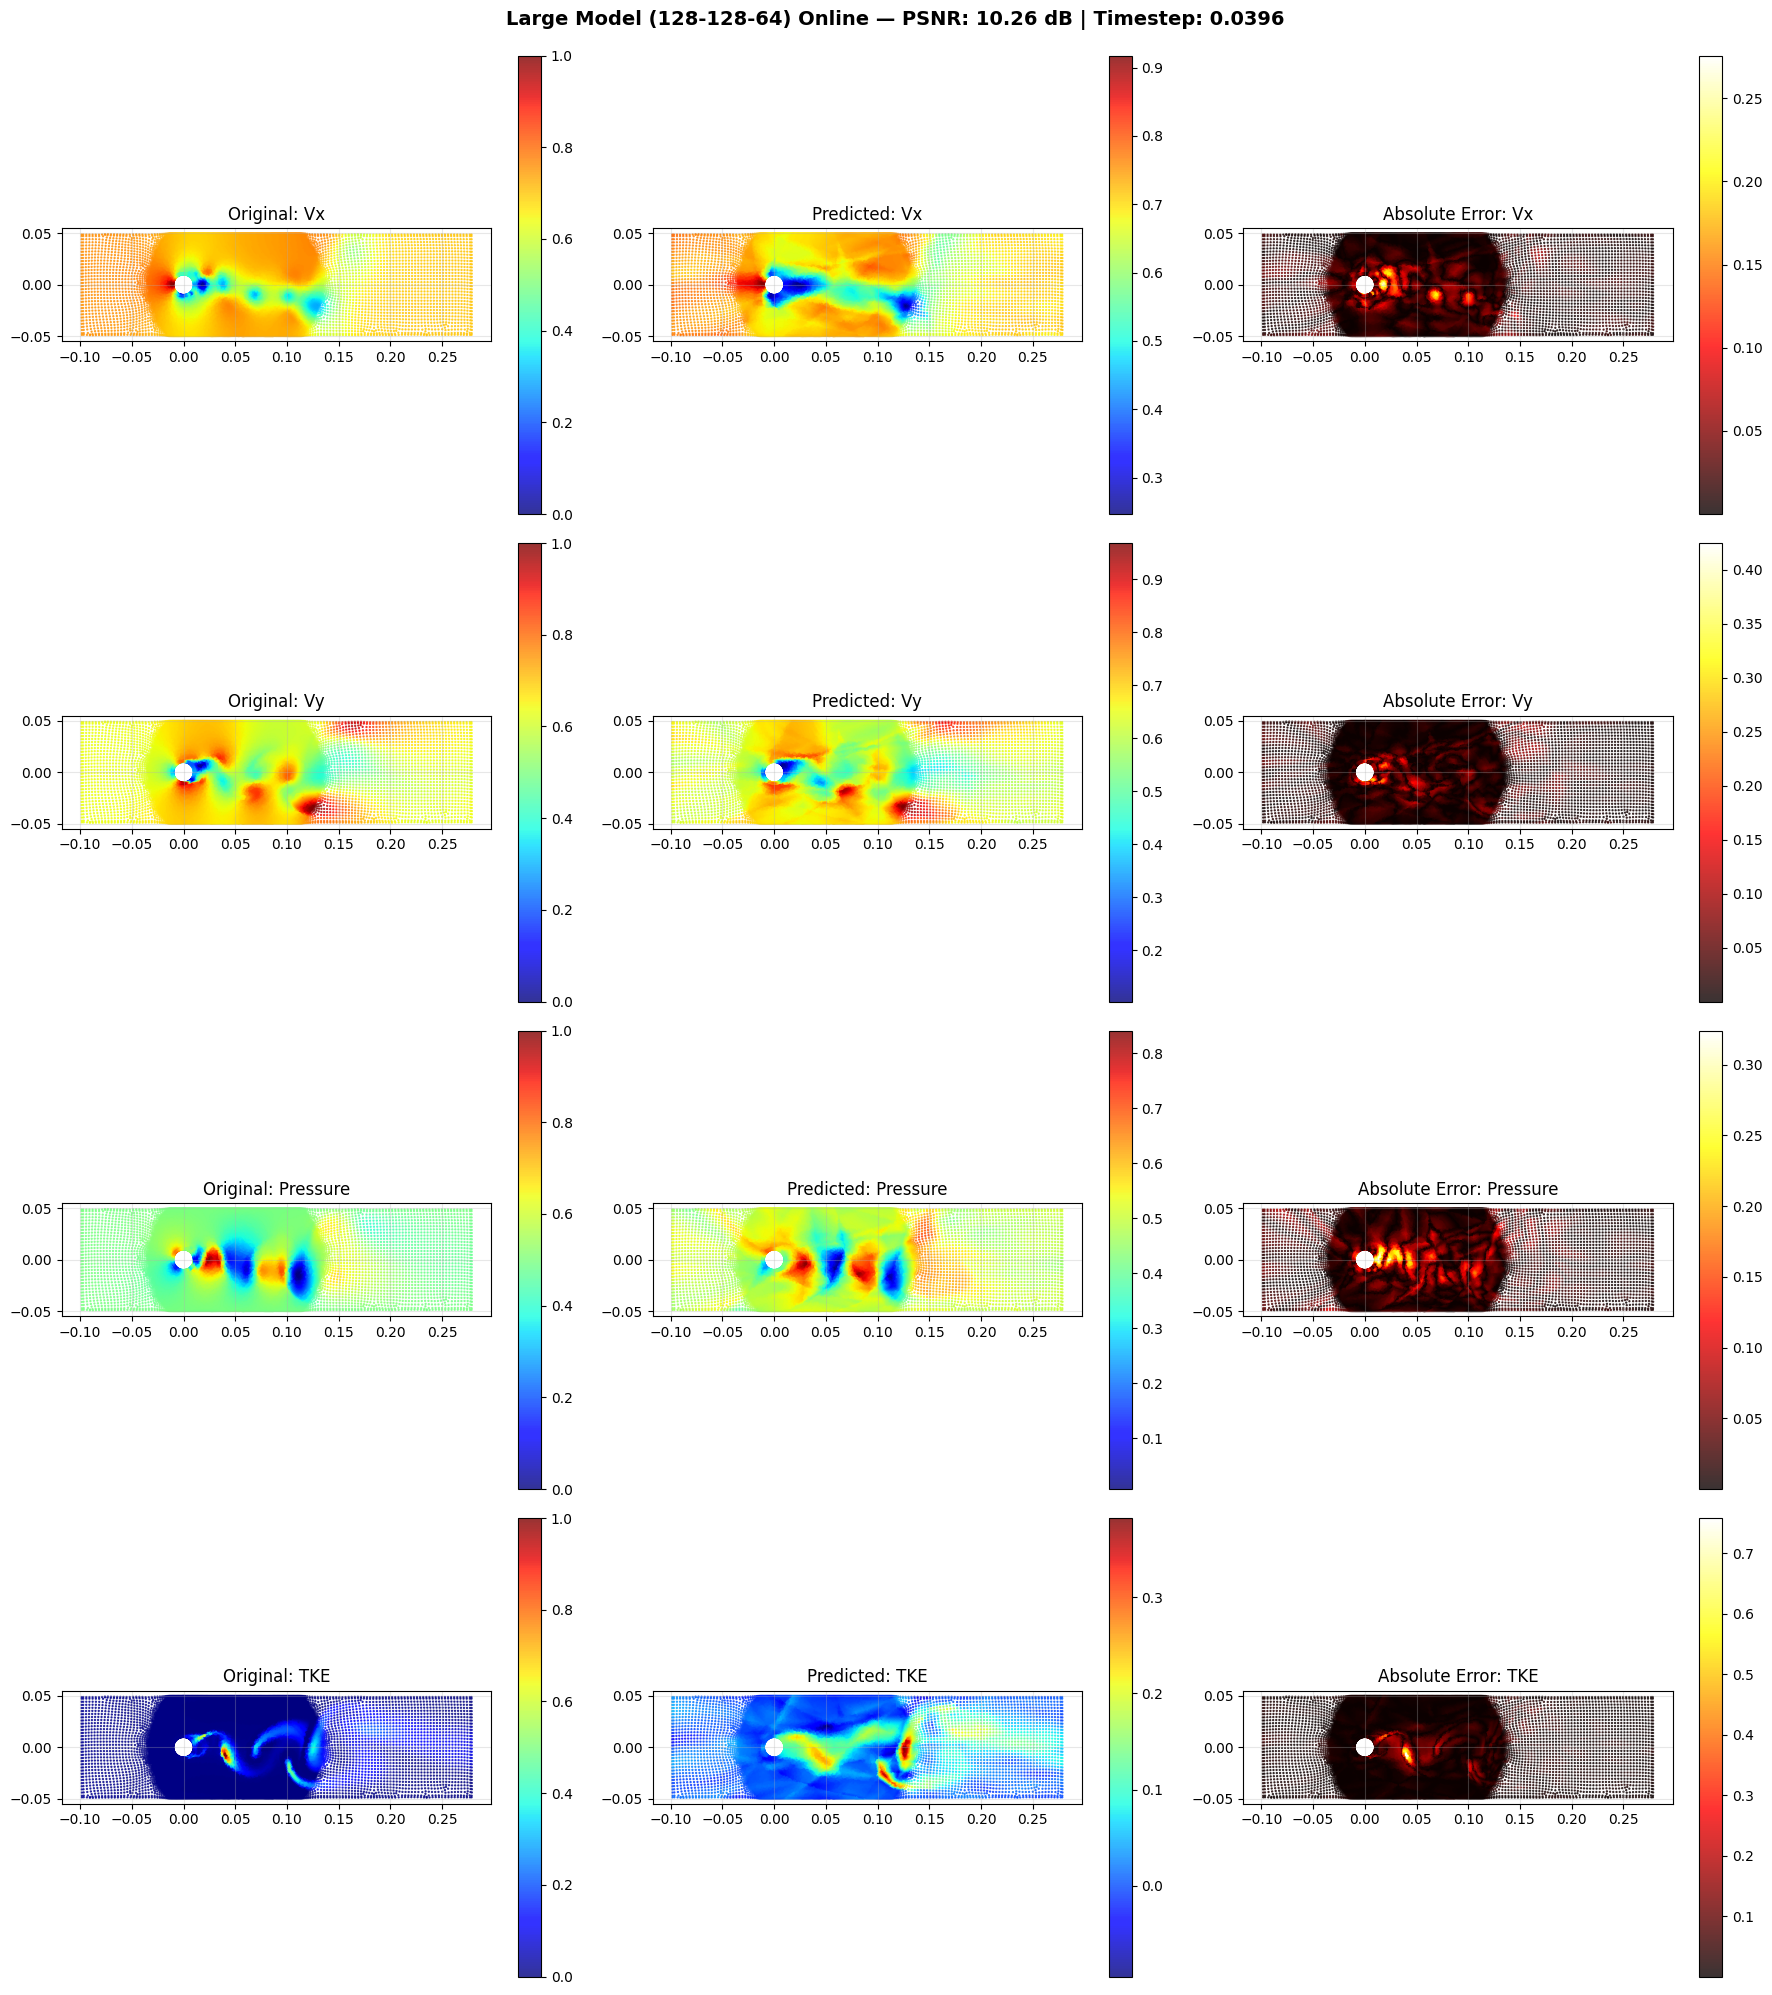

[Eval] Large model evaluation completed


In [11]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (idx, name) in enumerate(zip(feature_indices, feature_names)):
    original = target_t[:, idx]
    predicted = large_pred_t[:, idx]
    error = large_errors_t[:, idx]

    sc1 = axes[row, 0].scatter(x, y, c=original, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 0].set_title(f'Original: {name}')
    axes[row, 0].set_aspect('equal')
    axes[row, 0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[row, 0])

    sc2 = axes[row, 1].scatter(x, y, c=predicted, cmap='jet', s=0.5, alpha=0.8)
    axes[row, 1].set_title(f'Predicted: {name}')
    axes[row, 1].set_aspect('equal')
    axes[row, 1].grid(True, alpha=0.3)
    plt.colorbar(sc2, ax=axes[row, 1])

    sc3 = axes[row, 2].scatter(x, y, c=error, cmap='hot', s=0.5, alpha=0.8)
    axes[row, 2].set_title(f'Absolute Error: {name}')
    axes[row, 2].set_aspect('equal')
    axes[row, 2].grid(True, alpha=0.3)
    plt.colorbar(sc3, ax=axes[row, 2])

plt.suptitle(f'Large Model (128-128-64) Online — PSNR: {large_psnr:.2f} dB | Timestep: {TIMESTEP}',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{LARGE_VIZ_DIR}/large_online_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

large_eval_metrics = {
    'model': 'large_model_online_final.pth',
    'architecture': '4-128-128-64-4',
    'training_mode': 'online_streaming',
    'parameters': sum(p.numel() for p in large_model.parameters()),
    'psnr_db': float(large_psnr),
    'ssim': float(large_ssim)
}

with open(f"{LARGE_VIZ_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(large_eval_metrics, f, indent=2)

print("[Eval] Large model evaluation completed")

---
## 3. Model Comparison

In [12]:
print("=" * 65)
print("ONLINE TRAINING — MODEL COMPARISON SUMMARY")
print("=" * 65)
print(f"{'Metric':<25} {'Base (64-64-32)':>18} {'Large (128-128-64)':>20}")
print("-" * 65)
print(f"{'Parameters':<25} {sum(p.numel() for p in base_model.parameters()):>18,} {sum(p.numel() for p in large_model.parameters()):>20,}")
print(f"{'Model Size (KB)':<25} {sum(p.numel() for p in base_model.parameters()) * 4 / 1024:>18.2f} {sum(p.numel() for p in large_model.parameters()) * 4 / 1024:>20.2f}")
print(f"{'Windows':<25} {NUM_WINDOWS:>18} {NUM_WINDOWS:>20}")
print(f"{'Epochs/Window':<25} {EPOCHS_PER_WINDOW:>18} {EPOCHS_PER_WINDOW:>20}")
print(f"{'Total Epochs':<25} {NUM_WINDOWS * EPOCHS_PER_WINDOW:>18} {NUM_WINDOWS * EPOCHS_PER_WINDOW:>20}")
print(f"{'Final Window Loss':<25} {base_metrics['loss'][-1]:>18.6f} {large_metrics['loss'][-1]:>20.6f}")
print(f"{'Final Window PSNR (dB)':<25} {base_metrics['psnr'][-1]:>18.2f} {large_metrics['psnr'][-1]:>20.2f}")
print(f"{'Final Window SSIM':<25} {base_metrics['ssim'][-1]:>18.4f} {large_metrics['ssim'][-1]:>20.4f}")
print(f"{'Final Rel. Error (%)':<25} {base_metrics['relative_error'][-1]:>18.2f} {large_metrics['relative_error'][-1]:>20.2f}")
print(f"{'Eval PSNR (dB)':<25} {base_psnr:>18.2f} {large_psnr:>20.2f}")
print(f"{'Eval SSIM':<25} {base_ssim:>18.4f} {large_ssim:>20.4f}")
print("=" * 65)

ONLINE TRAINING — MODEL COMPARISON SUMMARY
Metric                       Base (64-64-32)   Large (128-128-64)
-----------------------------------------------------------------
Parameters                             6,692               25,668
Model Size (KB)                        26.14               100.27
Windows                                  100                  100
Epochs/Window                            100                  100
Total Epochs                           10000                10000
Final Window Loss                   0.003411             0.002515
Final Window PSNR (dB)                 24.67                25.99
Final Window SSIM                     0.8904               0.8994
Final Rel. Error (%)                   11.02                 9.47
Eval PSNR (dB)                          4.63                10.26
Eval SSIM                             0.6886               0.6986
